In [1]:
import gym
import torch
from powderworld import PowderWorld
import powder_dists
import numpy as np
from IPython import display as ipythondisplay
import matplotlib.pyplot as plt
import time
from tqdm import tqdm


In [2]:
import torch.nn as nn
import torch.nn.functional as F
import torchvision

class Block(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.relu  = nn.ReLU()
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
    
    def forward(self, x):
        return self.relu(self.conv2(self.relu(self.conv1(x))))
    
class Encoder(nn.Module):
    def __init__(self, chs):
        super().__init__()
        self.enc_blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs)-1)])
        self.pool       = nn.MaxPool2d(2)
    
    def forward(self, x):
        ftrs = []
        for block in self.enc_blocks:
            x = block(x)
            ftrs.append(x)
            x = self.pool(x)
        return ftrs
    
class Decoder(nn.Module):
    def __init__(self, chs):
        super().__init__()
        self.chs         = chs
        self.upconvs    = nn.ModuleList([nn.ConvTranspose2d(chs[i], chs[i+1], 2, 2) for i in range(len(chs)-1)])
        self.dec_blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs)-1)]) 
        
    def forward(self, x, encoder_features):
        for i in range(len(self.chs)-1):
            x        = self.upconvs[i](x)
            enc_ftrs = self.crop(encoder_features[i], x)
            x        = torch.cat([x, enc_ftrs], dim=1)
            x        = self.dec_blocks[i](x)
        return x
    
    def get_features(self, x, encoder_features):
        ftrs = []
        for i in range(len(self.chs)-1):
            x        = self.upconvs[i](x)
            enc_ftrs = self.crop(encoder_features[i], x)
            x        = torch.cat([x, enc_ftrs], dim=1)
            x        = self.dec_blocks[i](x)
            ftrs.append(x)
        return ftrs
    
    def crop(self, enc_ftrs, x):
        _, _, H, W = x.shape
        enc_ftrs   = torchvision.transforms.CenterCrop([H, W])(enc_ftrs)
        return enc_ftrs

class WorldModel(nn.Module):
    def __init__(self):
        super().__init__()
        enc_chs=(14, 32, 64, 128)
        dec_chs=(128, 64, 32)
        num_class=14
        self.encoder     = Encoder(enc_chs)
        self.decoder     = Decoder(dec_chs)
        self.head        = nn.Conv2d(dec_chs[-1], num_class, 1)

    def forward(self, x):
        enc_ftrs = self.encoder(x)
        out = self.decoder(enc_ftrs[::-1][0], enc_ftrs[::-1][1:])
        out = self.head(out)
        return out

In [3]:
net = WorldModel()

In [4]:
np.sum([p.numel() for p in net.parameters()])

470126

In [3]:
TOTAL_STEP = 128
STEP_SIZE = 8
BATCH_SIZE = 64
PER_ITER = BATCH_SIZE*int(TOTAL_STEP/STEP_SIZE) # 1024

def lim(x):
    return np.clip(1, 63, int(x))

@torch.no_grad()
def make_data_batch(pw, elems, test=False, num_tasks=1000000, num_lines=5, num_circles=0, num_squares=0):
    ci = 0
    data_batch = torch.zeros((PER_ITER, 2, 64, 64), dtype=torch.int64, device=pw.device)
    world = torch.zeros((BATCH_SIZE, pw.NUM_CHANNEL, 64, 64), dtype=torch.float32, device=pw.device)
    if not test:
        for b in range(BATCH_SIZE):
            powder_dists.make_world(pw, world[b:b+1], elems, num_tasks, num_lines, num_circles, num_squares)
    else:
        for b in range(BATCH_SIZE):
            powder_dists.make_test(pw, world[b:b+1], b % 8)

    last_world = torch.argmax(world[:, :14], dim=1).clone().int()
    for t in range(TOTAL_STEP):
        if (t+1) % STEP_SIZE == 0:
            new_world = torch.argmax(world[:, :14], dim=1).clone().int()
            data_batch[ci:ci+BATCH_SIZE, 0] = last_world
            data_batch[ci:ci+BATCH_SIZE, 1] = new_world
            last_world = new_world
            ci += BATCH_SIZE
        world = pw(world)
    return data_batch

In [4]:
class ReplayBuffer:
    def __init__(self, capacity, device):
        self.buffer = torch.zeros((capacity, 2, 64, 64), dtype=torch.int64, device=device)
        self.capacity = capacity
        self.size = 0
        self.idx = 0

    def append(self, data_batch):
        dlen = data_batch.shape[0]
        self.buffer[self.idx:self.idx+dlen] = data_batch
        self.idx = (self.idx+dlen) % self.capacity
        self.size = min(self.capacity, self.size + dlen)

    def sample(self, batch_size):
        indices = np.random.choice(self.size, batch_size, replace=False)
        return self.buffer[indices]

In [5]:
def train(savedir, device, num_elems, num_tasks, num_lines, num_circles, num_squares):
    import wandb
    config = {
        'num_elems': num_elems,
        'num_tasks': num_tasks,
        'num_lines': num_lines,
        'num_circles': num_circles,
        'num_squares': num_squares
    }
    print("Training with {}".format(config))
    model = WorldModel().to(device)
    optim = torch.optim.Adam(model.parameters(), lr=.005)
    loss_fn = torch.nn.CrossEntropyLoss()
    
    run = wandb.init(
        project="powder_wm_5",
        config=config,
        save_code=False,
    )
    run.name = savedir
    
    wandb_log = {}
    
    pw_device = device
    pw = PowderWorld(pw_device)
    def show_row(worlds, name):
        worlds = F.pad(worlds, (0, 0, 0, 0, 0, 6))
        imgs = [pw.render(worlds[x:x+1].to(pw_device)) for x in range(4)]
        fig = plt.figure(figsize=(4*4,4))
        axarr = fig.subplots(1, 4)
        for b in range(4):
            axarr[b].imshow(imgs[b])
        del imgs
        wandb_log[name] = wandb.Image(fig)
        fig.show()
        plt.close(fig)
        del fig
        
    def expand(x):
        x = F.one_hot(x, 14)
        x = torch.permute(x, (0,3,1,2)).float()
        return x
    
    all_elems = ['empty', 'sand', 'water', 'wall', 'plant', 'fire', 'wood', 'ice', 'lava', 'dust', 'cloner', 'gas', 'acid', 'stone']
    elems = all_elems[:num_elems]
    
    # Test on same settings.
    buffer_validation = ReplayBuffer(1024, pw_device)
    buffer_validation.append(make_data_batch(pw, elems, test=False,
        num_tasks=num_tasks, num_lines=num_lines, num_circles=num_circles, num_squares=num_squares))
    idx = torch.randperm(buffer_validation.buffer.shape[0])
    buffer_validation.buffer = buffer_validation.buffer[idx].view(buffer_validation.buffer.size())
    
    # Test on Transfer set.
    buffer_test = ReplayBuffer(1024, pw_device)
    buffer_test.append(make_data_batch(pw, elems, test=True,
        num_tasks=None, num_lines=None, num_circles=None, num_squares=None))
    idx = torch.randperm(buffer_test.buffer.shape[0])
    buffer_test.buffer = buffer_test.buffer[idx].view(buffer_test.buffer.size())
    
    # Test on all elements.
    buffer_half = ReplayBuffer(1024, pw_device)
    buffer_half.append(make_data_batch(pw, all_elems, test=False,
        num_tasks=100000, num_lines=5, num_circles=0, num_squares=0))
    idx = torch.randperm(buffer_half.buffer.shape[0])
    buffer_half.buffer = buffer_half.buffer[idx].view(buffer_half.buffer.size())
    
    bsize = 50
    buffer = ReplayBuffer(1024 * bsize, pw_device)
    for i in tqdm(range(bsize)):
        buffer.append(make_data_batch(pw, elems, test=False,
            num_tasks=num_tasks, num_lines=num_lines, num_circles=num_circles, num_squares=num_squares))

    BATCH_SIZE = 256
    for it in tqdm(range(5000)):
        # Make new data
        buffer.append(make_data_batch(pw, elems, test=False,
            num_tasks=num_tasks, num_lines=num_lines, num_circles=num_circles, num_squares=num_squares))
        
        # Sample training Data
        batch = buffer.sample(BATCH_SIZE)
        start = expand(batch[:, 0])
        end = batch[:, 1]
        
        # Train
        optim.zero_grad()
        out = model(start)
        loss = loss_fn(out, end)
        loss.backward()
        optim.step()
        
        wandb_log['loss'] = loss.item()
        
        # Debug Log
        if it % 100 == 0:
            with torch.no_grad():
                t_start = expand(buffer_validation.buffer[:, 0])
                t_end = buffer_validation.buffer[:, 1]
                t_out = model(t_start)
                test_loss = loss_fn(t_out, t_end).item()
                show_row(t_start, 'validation_start')
                show_row(expand(torch.argmax(t_out, dim=1)),'validation_pred')
                show_row(expand(t_end),'validation_truth')
                wandb_log['loss_validation'] = test_loss
                
                t_start = expand(buffer_test.buffer[:, 0])
                t_end = buffer_test.buffer[:, 1]
                t_out = model(t_start)
                test_loss = loss_fn(t_out, t_end).item()
                show_row(t_start, 'test_start')
                show_row(expand(torch.argmax(t_out, dim=1)),'test_pred')
                show_row(expand(t_end),'test_truth')
                wandb_log['loss_test'] = test_loss
                
                t_start = expand(buffer_half.buffer[:, 0])
                t_end = buffer_half.buffer[:, 1]
                t_out = model(t_start)
                test_loss = loss_fn(t_out, t_end).item()
                show_row(t_start, 'half_start')
                show_row(expand(torch.argmax(t_out, dim=1)),'half_pred')
                show_row(expand(t_end),'half_truth')
                wandb_log['loss_half'] = test_loss
        
        wandb.log(wandb_log)
        wandb_log.clear()
                
        if (it+1) % 1000 == 0:
            torch.save(model.state_dict(), '/data/scratch/kvfrans/wm_dr_data/wm_{}.pt'.format(savedir))

In [8]:
def test(savedir, display=False, device='cuda'):
    logs = []
    model = WorldModel().to(device)
    optim = torch.optim.Adam(model.parameters(), lr=.005)
    model.load_state_dict(torch.load("/data/scratch/kvfrans/wm_dr_data/wm_{}.pt".format(savedir), map_location=device))
    loss_fn = torch.nn.CrossEntropyLoss()
    
    pw_device = device
    pw = PowderWorld(pw_device)
    def show_row(worlds, savedir2=None):
        worlds = F.pad(worlds, (0, 0, 0, 0, 0, 6))
        imgs = [pw.render(worlds[x:x+1].to(pw_device)) for x in range(8)]
        fig = plt.figure(figsize=(4*8,4))
        axarr = fig.subplots(1, 8)
        for b in range(8):
            axarr[b].imshow(imgs[b])
        fig.show()
#         if savedir2 is None:
#             plt.show()
#         else:
        fig.savefig(savedir2)
        plt.show()
        del fig
        
    def expand(x):
        x = F.one_hot(x, 14)
        x = torch.permute(x, (0,3,1,2)).float()
        return x
    
    np.random.seed(0)
    torch.manual_seed(0)
    
    world = torch.zeros((8, pw.NUM_CHANNEL, 64, 64), dtype=torch.float32, device=pw.device)
    for b in range(8):
        powder_dists.make_test(pw, world[b:b+1], b % 8)

    with torch.no_grad():
#         print("Test")
        t_start = world[:,:14]
        t = t_start
        t = model(t)
        t = expand(torch.argmax(t, dim=1))
        t = model(t)
#         t = expand(torch.argmax(t, dim=1))
#         t = model(t)
#         t = expand(torch.argmax(t, dim=1))
#         t = model(t)
        show_row(expand(torch.argmax(t, dim=1)), 'figs/wm_{}.png'.format(savedir))
    return logs

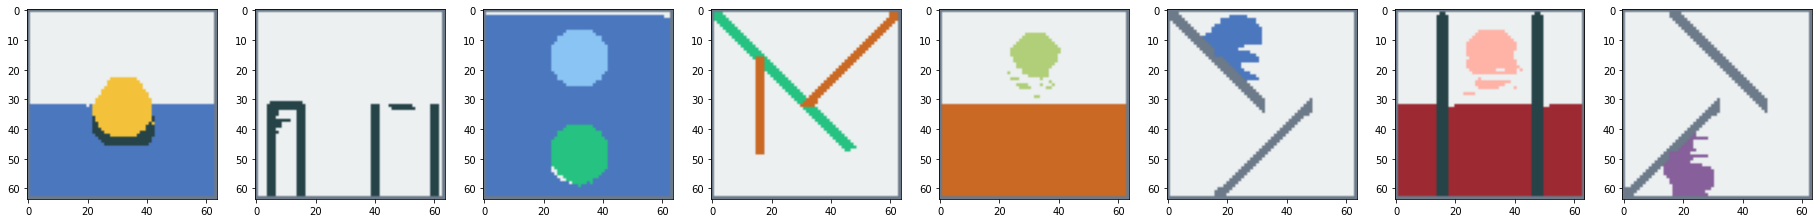

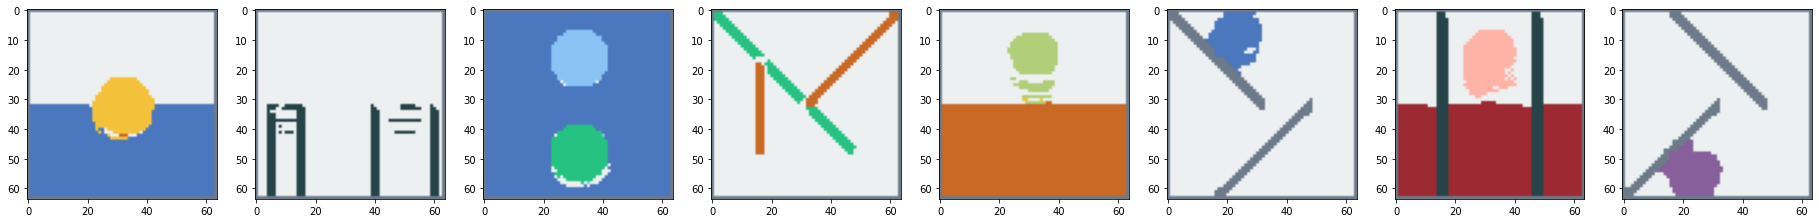

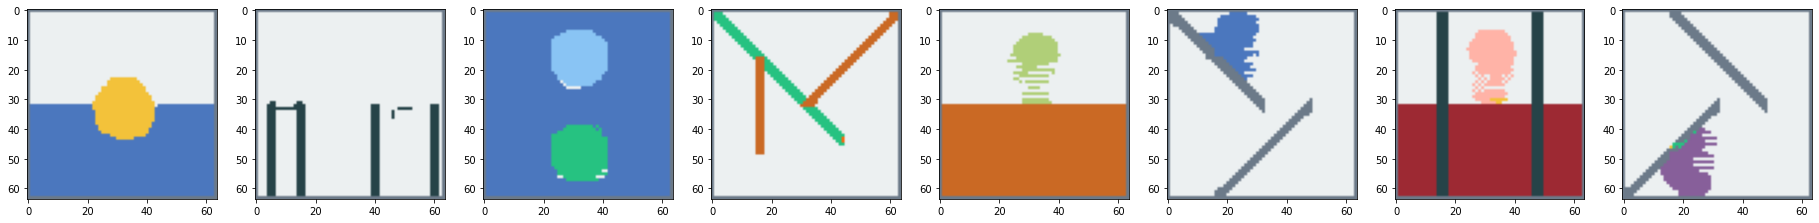

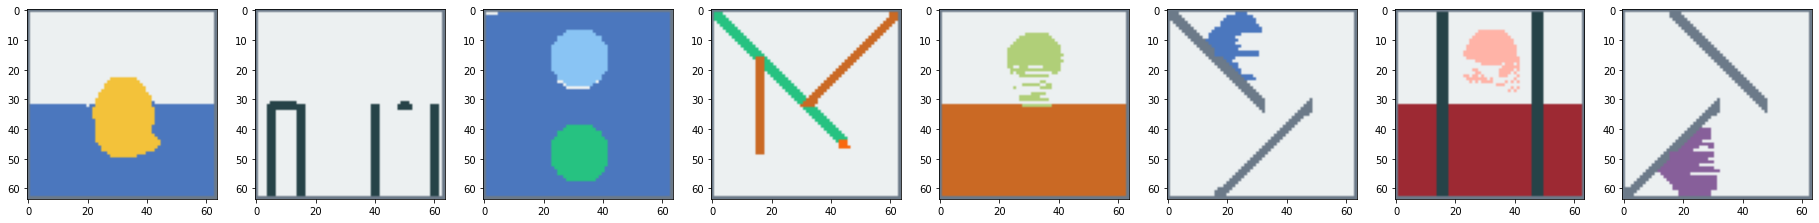

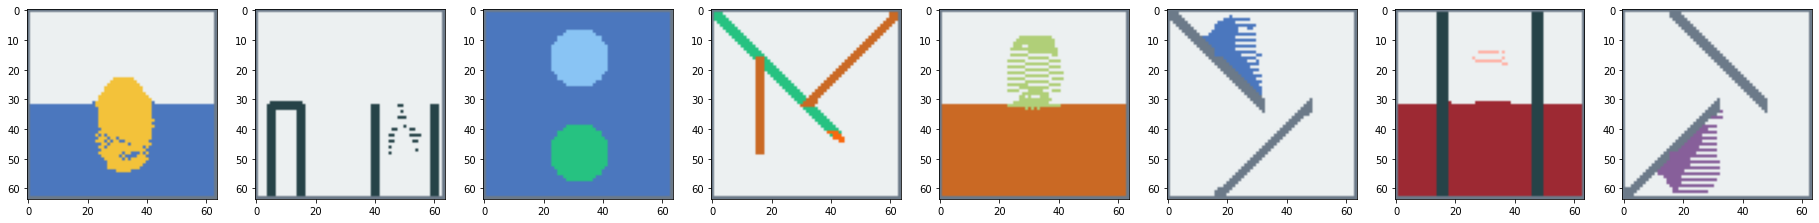

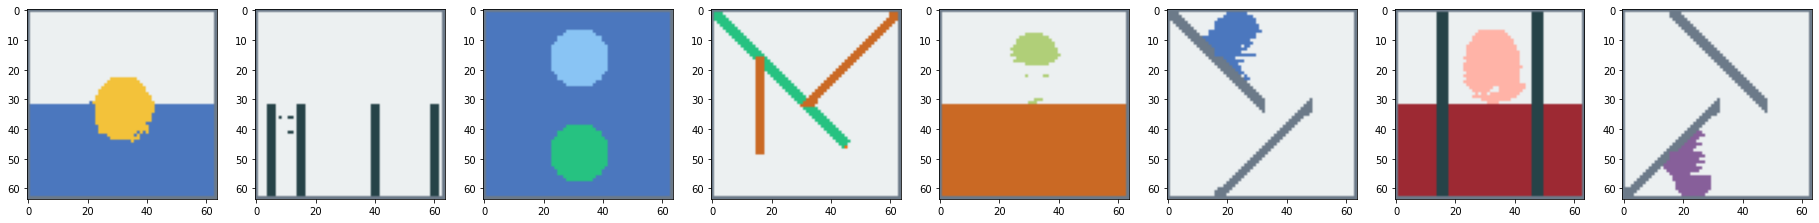

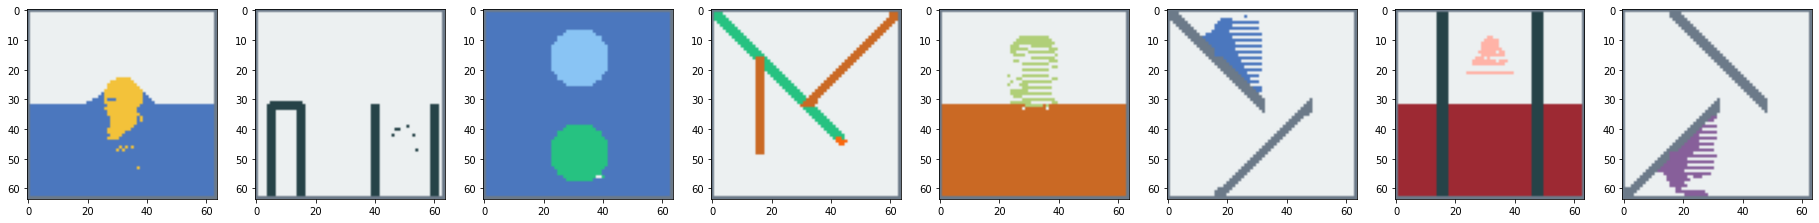

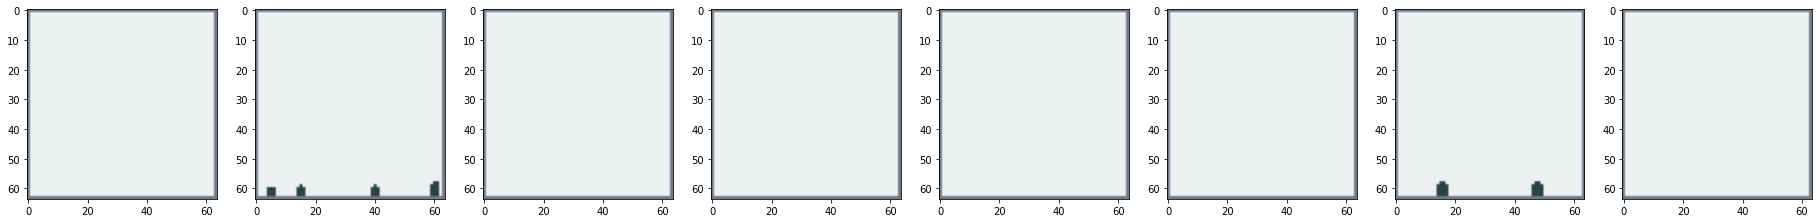

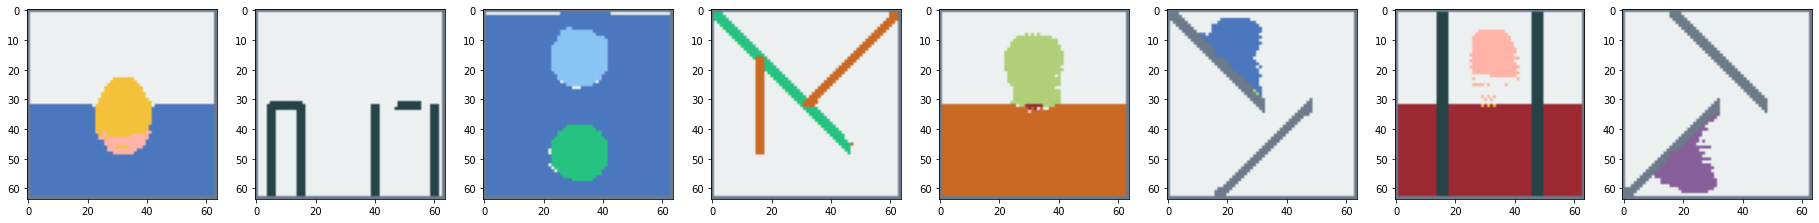

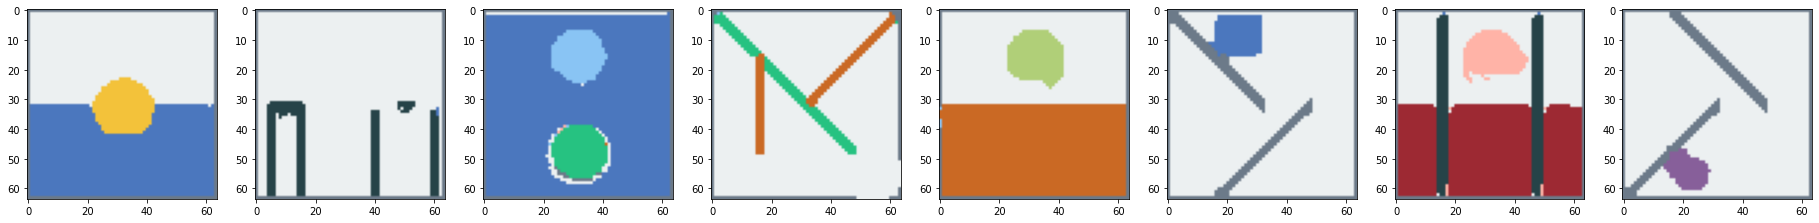

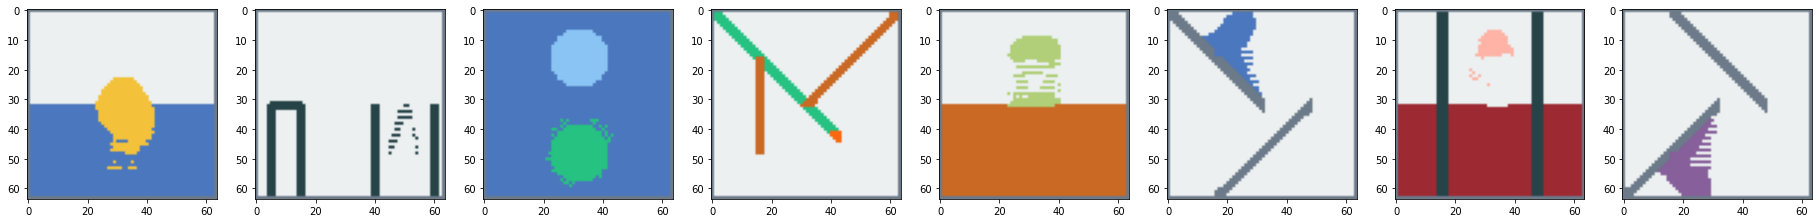

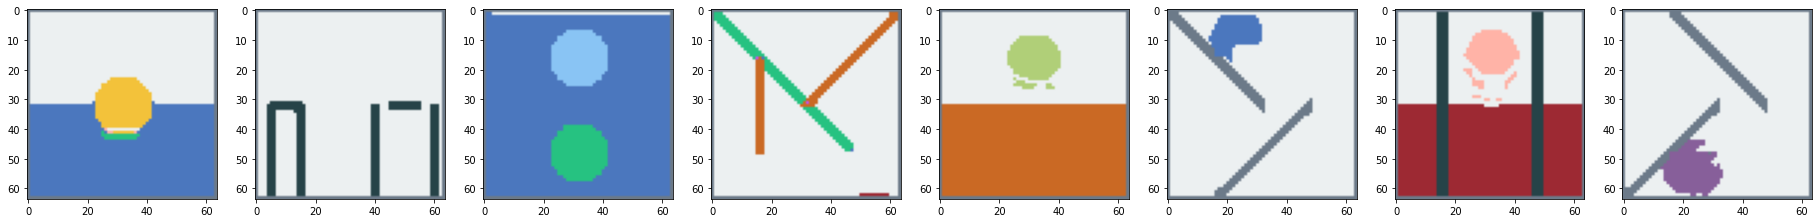

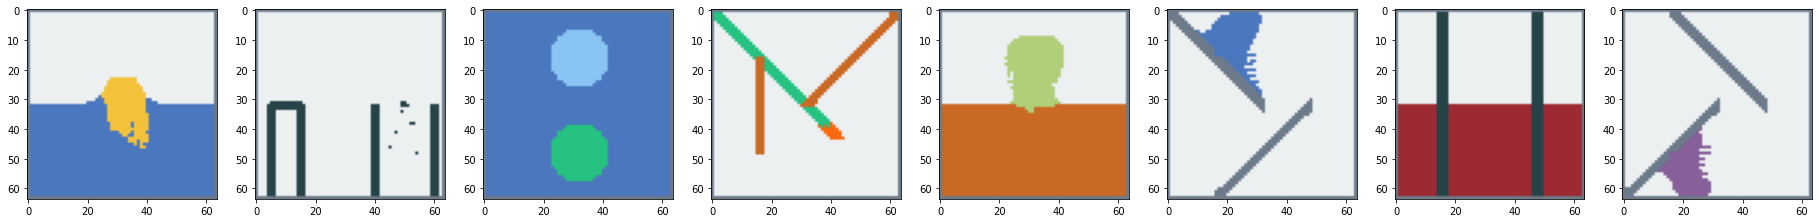

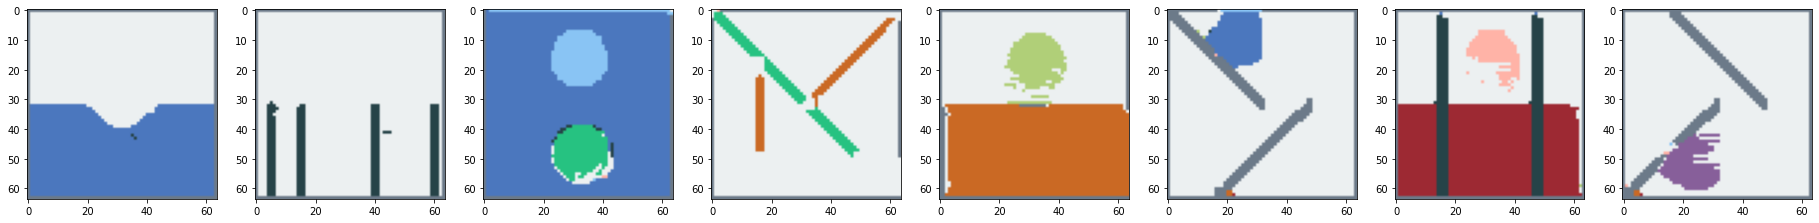

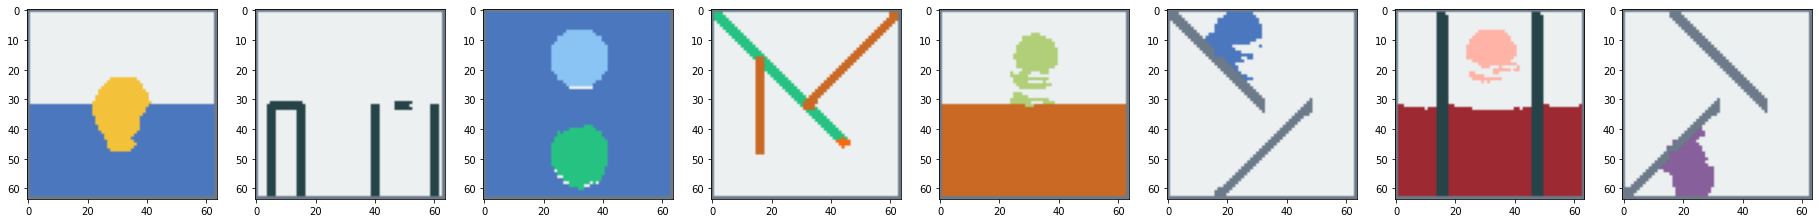

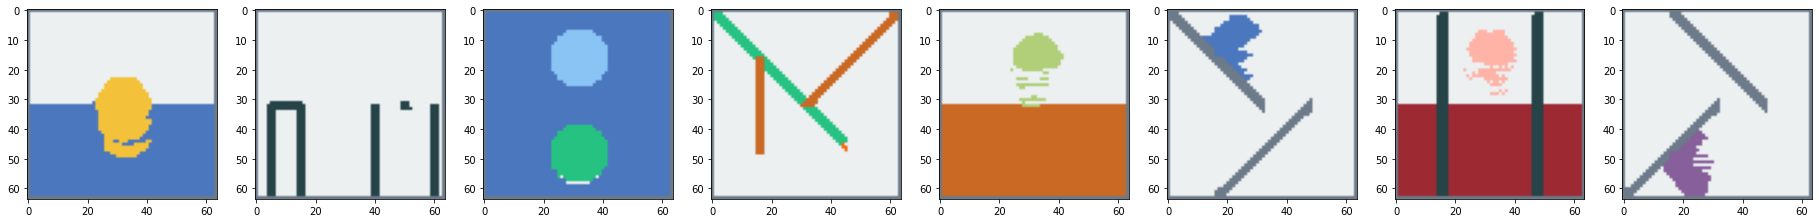

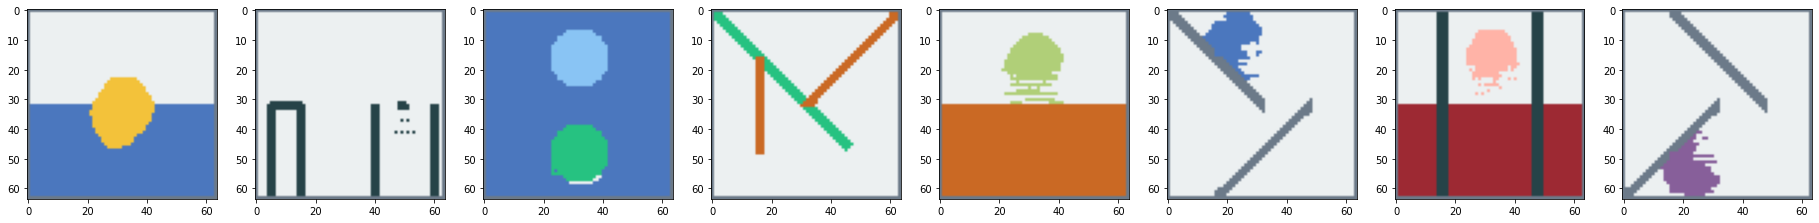

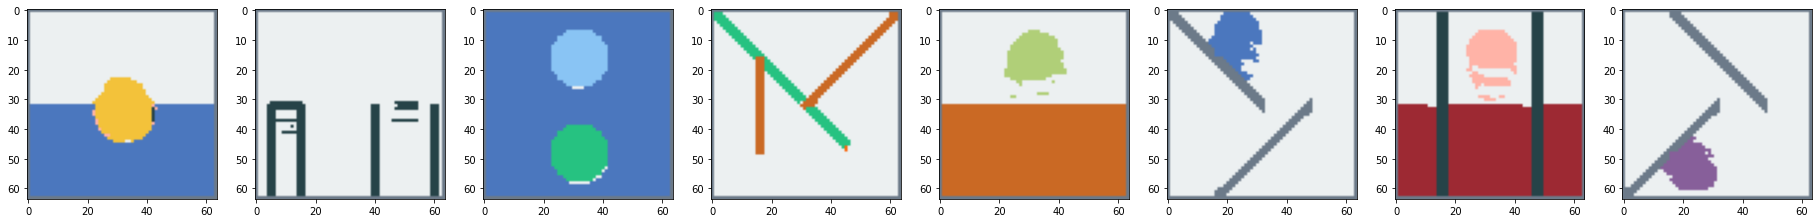

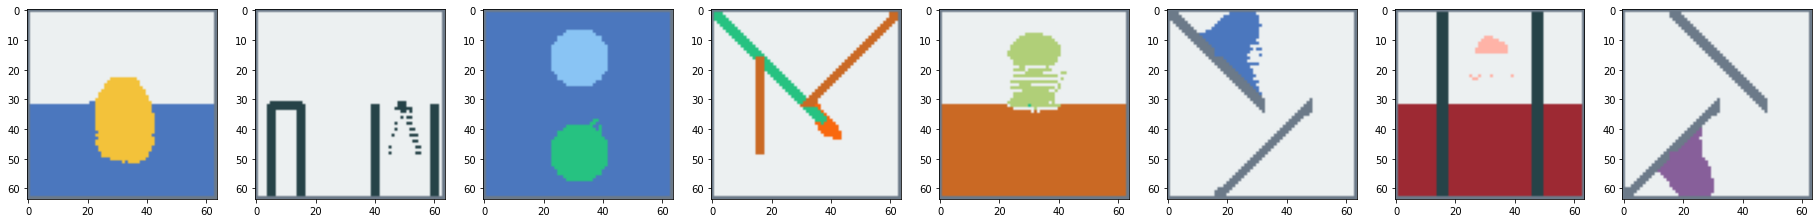

In [10]:
import sys
if __name__ == "__main__":
    if not 'ipykernel_launcher.py' in sys.argv[0]:
        import argparse
        parser = argparse.ArgumentParser()
        parser.add_argument('func') # Train or Test?
        parser.add_argument('--savedir')
        parser.add_argument('--num_elems', type=int)
        parser.add_argument('--num_tasks', type=int)
        parser.add_argument('--num_lines', type=int)
        parser.add_argument('--num_circles', type=int)
        parser.add_argument('--num_squares', type=int)

        args = parser.parse_args()
        print(args)

        if args.func == 'train':
            # Train a worldmodel on elems. Save as savedir.pt.
            train(args.savedir, 'cuda', args.num_elems, args.num_tasks, args.num_lines, args.num_circles, args.num_squares)
        elif args.func == 'test':
            # Test the worldmodel at savedir.pt, on hardcoded test set. Save logs at logs_savedir.txt.
            test_suite(args.savedir)
        else:
            print("Invalid function!")
    else:
        test('comp-s')
        test('comp-c')
        test('comp-l')
        test('comp-sc')
        test('comp-sl')
        test('comp-cl')
        test('comp-scl')
        test('lines1-r')
        test('lines2-r')
        test('lines3-r')
        test('lines4-r')
        test('lines5-r')
        test('lines6-r')
        test('tasknum1')
        test('tasknum2')
        test('tasknum3')
        test('tasknum4')
        test('tasknum5')
        test('tasknum6')
        

In [ ]:
# train_with_elems(['sand', 'water', 'wall'], 'wm3', device='cuda:1')

In [ ]:
# For visualization
# test_with_elems(['sand', 'water', 'wall', 'plant', 'fire'], '/data/scratch/kvfrans/wm_dr_data/wm_wm7.pt', display=True)
# test_with_elems(['gas', 'acid', 'stone'], '/data/scratch/kvfrans/wm_dr_data/wm_wm7.pt', display=True, device='cuda:1')